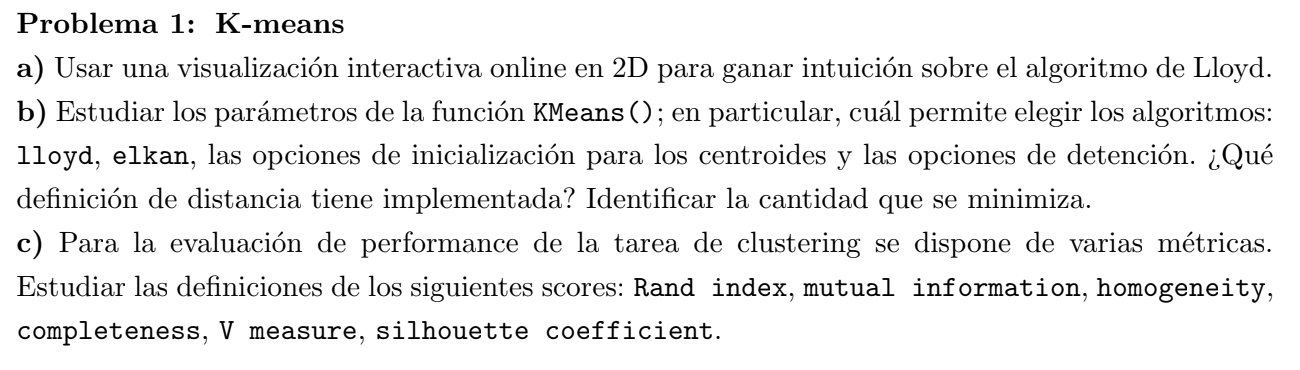

| Parámetro      | Descripción                                                                   |
| -------------- | ----------------------------------------------------------------------------- |
| `n_clusters`   | Número de clusters a formar (valor de k).                                     |
| `init`         | Método para inicializar los centroides: `'k-means++'`, `'random'` o un array. |
| `n_init`       | Número de veces que se ejecuta k-means con diferentes centroides iniciales.   |
| `max_iter`     | Máximo número de iteraciones por corrida.                                     |
| `tol`          | Tolerancia para declarar convergencia.                                        |
| `algorithm`    | Algoritmo usado: `'lloyd'`, `'elkan'`, `'auto'`, `'full'`.                    |
| `random_state` | Semilla para reproducibilidad.                                                |


➤ ¿Qué definición de distancia tiene implementada?

Usa la distancia euclídea (L2) por defecto.
➤ ¿Qué cantidad se minimiza?

Minimiza la suma de distancias cuadradas entre cada punto y su centroide:

| Métrica                    | Idea principal                                                                                  |
| -------------------------- | ----------------------------------------------------------------------------------------------- |
| **Rand Index (RI)**        | Proporción de decisiones correctas (pares bien agrupados o bien separados).                     |
| **Mutual Information**     | Medida de información compartida entre clustering y ground truth (más robusta a permutaciones). |
| **Homogeneity**            | Cada cluster contiene solo elementos de una misma clase.                                        |
| **Completeness**           | Todos los elementos de una clase están en el mismo cluster.                                     |
| **V-measure**              | Promedio armónico entre homogeneity y completeness.                                             |
| **Silhouette Coefficient** | Mide qué tan similar es un punto a su propio cluster comparado con otros. Valores entre -1 y 1. |


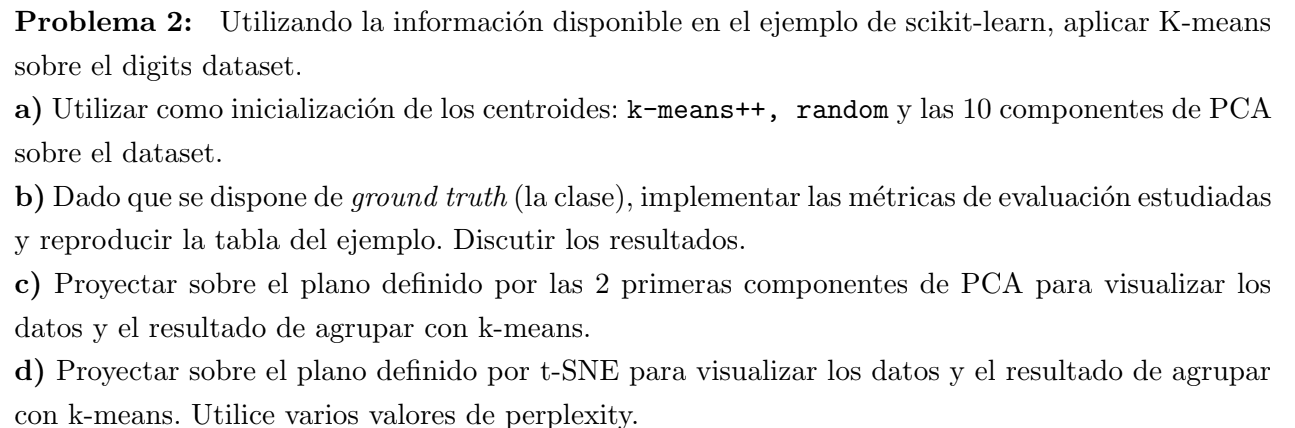

1. k-means++

    Es la inicialización por defecto y más usada.

    Idea: elige los primeros centroides de forma inteligente, maximizando su separación.

    Beneficio: evita malos mínimos locales, mejora convergencia y estabilidad.

2. random

    Elige k puntos al azar del dataset como centroides iniciales.

    Más rápido, pero más propenso a resultados malos o inconsistentes (por quedar atrapado en mínimos locales malos).

3. PCA

    Se usa como inicialización un subconjunto de los componentes principales del dataset.

    En este caso, se usaron los primeros k vectores de la matriz de componentes de PCA.

    Puede ser útil si hay estructura lineal, pero es una aproximación heurística. No siempre es mejor.

In [ ]:
import numpy as np

from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [ ]:
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.082s	69545	0.598	0.645	0.621	0.469	0.617	0.164
random   	0.071s	69735	0.681	0.723	0.701	0.574	0.698	0.188
PCA-based	0.024s	69513	0.600	0.647	0.622	0.468	0.618	0.156
__________________________________________________________________________________


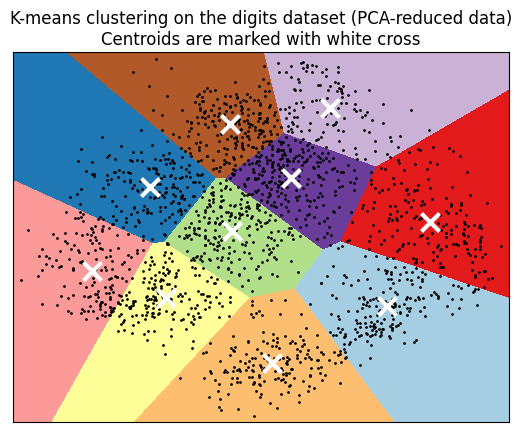

In [ ]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Métricas de Evaluación para K-means en Digits Dataset:
+------------------------+--------+
|        Métrica         | Valor  |
+------------------------+--------+
|       Rand Index       | 0.9019 |
|  Adjusted Rand Index   | 0.5305 |
|   Mutual Information   | 1.4720 |
|      Homogeneity       | 0.6393 |
|      Completeness      | 0.7083 |
|       V-measure        | 0.6720 |
| Silhouette Coefficient | 0.1356 |
+------------------------+--------+


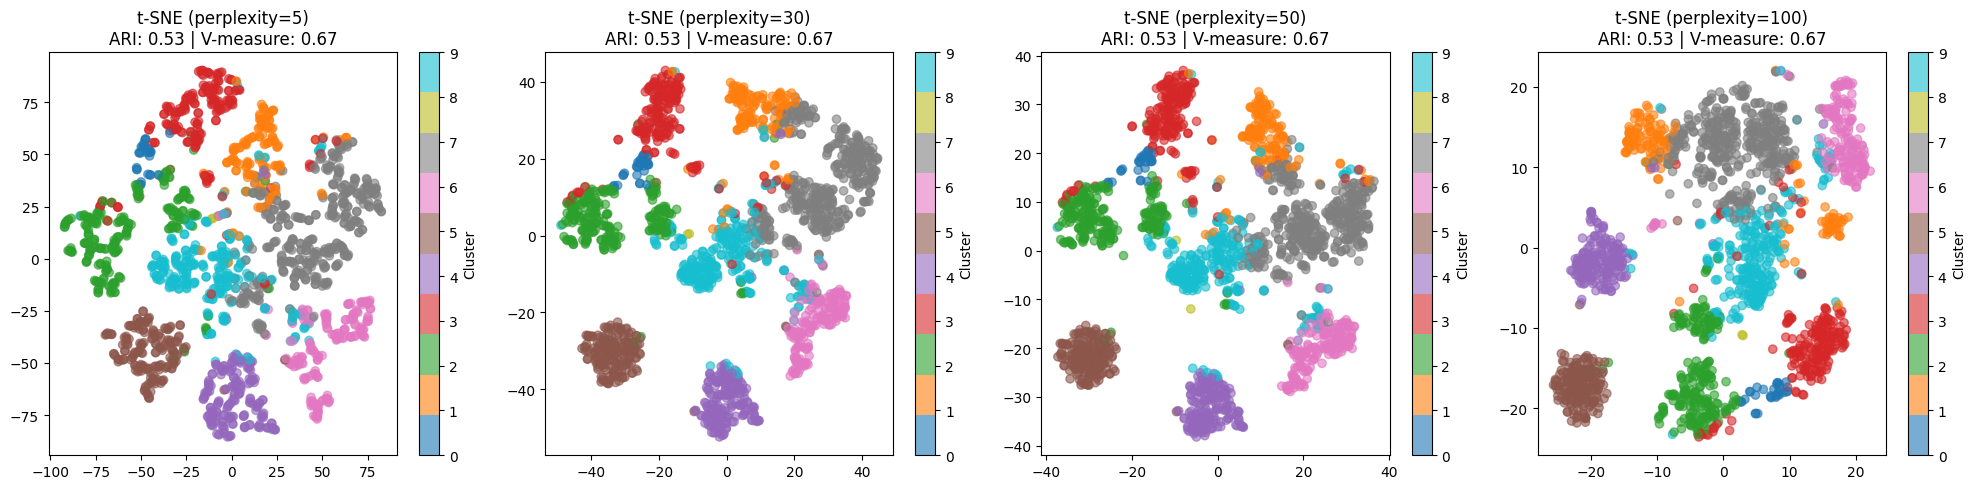

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (silhouette_score, adjusted_rand_score,
                            mutual_info_score, homogeneity_score,
                            completeness_score, v_measure_score,
                            rand_score)
from prettytable import PrettyTable

# 1. Cargar el dataset digits
digits = datasets.load_digits()
X = digits.data
y = digits.target

# 2. Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Aplicar K-means (usando k-means++ como inicialización)
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 4. Calcular todas las métricas
metrics = {
    'Rand Index': rand_score(y, clusters),
    'Adjusted Rand Index': adjusted_rand_score(y, clusters),
    'Mutual Information': mutual_info_score(y, clusters),
    'Homogeneity': homogeneity_score(y, clusters),
    'Completeness': completeness_score(y, clusters),
    'V-measure': v_measure_score(y, clusters),
    'Silhouette Coefficient': silhouette_score(X_scaled, clusters)
}

# 5. Mostrar métricas en tabla
table = PrettyTable()
table.field_names = ["Métrica", "Valor"]
for name, value in metrics.items():
    table.add_row([name, f"{value:.4f}"])
print("Métricas de Evaluación para K-means en Digits Dataset:")
print(table)

# 6. Visualización con t-SNE para diferentes valores de perplexity
perplexities = [5, 30, 50, 100]

plt.figure(figsize=(20, 5))
for i, perplexity in enumerate(perplexities, 1):
    # Aplicar t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    # Crear subplot
    plt.subplot(1, len(perplexities), i)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='tab10', alpha=0.6)
    plt.title(f't-SNE (perplexity={perplexity})\nARI: {metrics["Adjusted Rand Index"]:.2f} | V-measure: {metrics["V-measure"]:.2f}')
    plt.colorbar(scatter, label='Cluster')

plt.tight_layout()
plt.show()

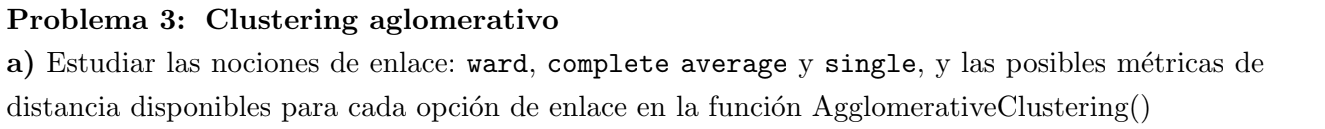

La función que se usa es:

sklearn.cluster.AgglomerativeClustering

Esta implementa clustering jerárquico aglomerativo, donde:

Se parte de cada punto como un cluster separado.

Se van fusionando pares de clusters según algún criterio ("linkage") hasta que se llega al número deseado de clusters.

---
Tipos de linkage (criterios de fusión)

  ward (método de Ward)

        Fusiona los dos clusters cuya unión minimiza el aumento de varianza total.

        Solo disponible con distancia euclídea (L2).

        Tiende a producir clusters de tamaño similar.

        Muy usado en datos continuos y bien distribuidos.
        
  complete (enlace completo)

        Se usa la mayor distancia entre cualquier par de puntos de dos clusters.

        Tiende a formar clusters compactos y separados.

        Es sensible a outliers.

  average (enlace promedio)

        Usa el promedio de distancias entre todos los pares de puntos entre dos clusters.

        Es un punto intermedio entre single y complete.

  single (enlace mínimo)

        Usa la menor distancia entre un par de puntos de los dos clusters.

        Produce clusters alargados o en forma de cadena.

        Muy sensible al ruido y a outliers.

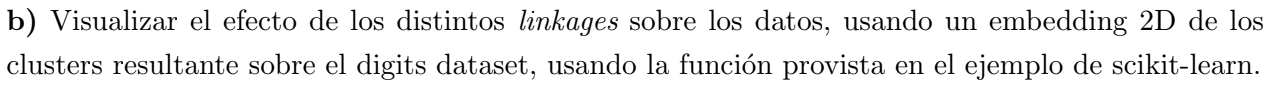

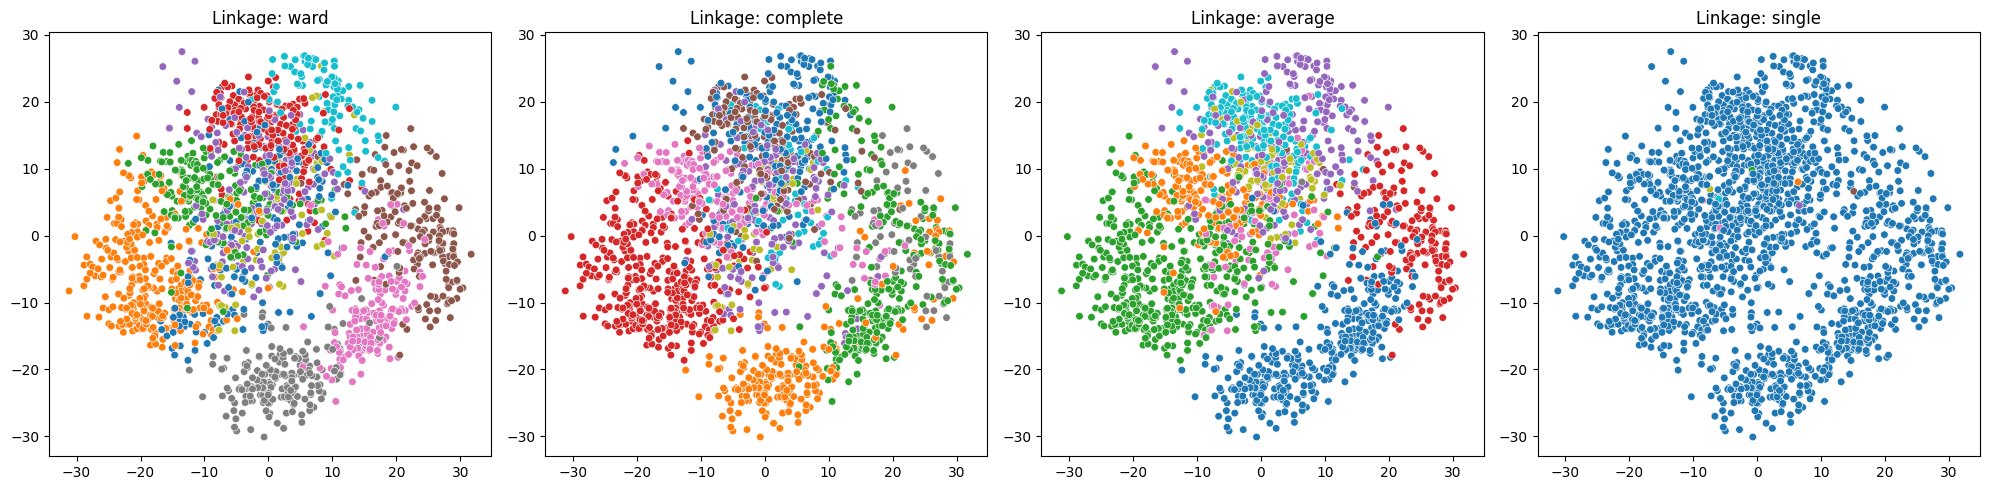

In [ ]:
from sklearn.datasets import load_digits
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset
digits = load_digits()
X = digits.data
k = len(set(digits.target))  # 10 dígitos

# Proyección a 2D con PCA
X_pca = PCA(n_components=2).fit_transform(X)

# Diferentes estrategias de linkage
linkages = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, linkage in zip(axes, linkages):
    # ward solo acepta euclidean
    model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = model.fit_predict(X)

    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='tab10',
        ax=ax, legend=None, s=30
    )
    ax.set_title(f"Linkage: {linkage}")

plt.tight_layout()
plt.show()


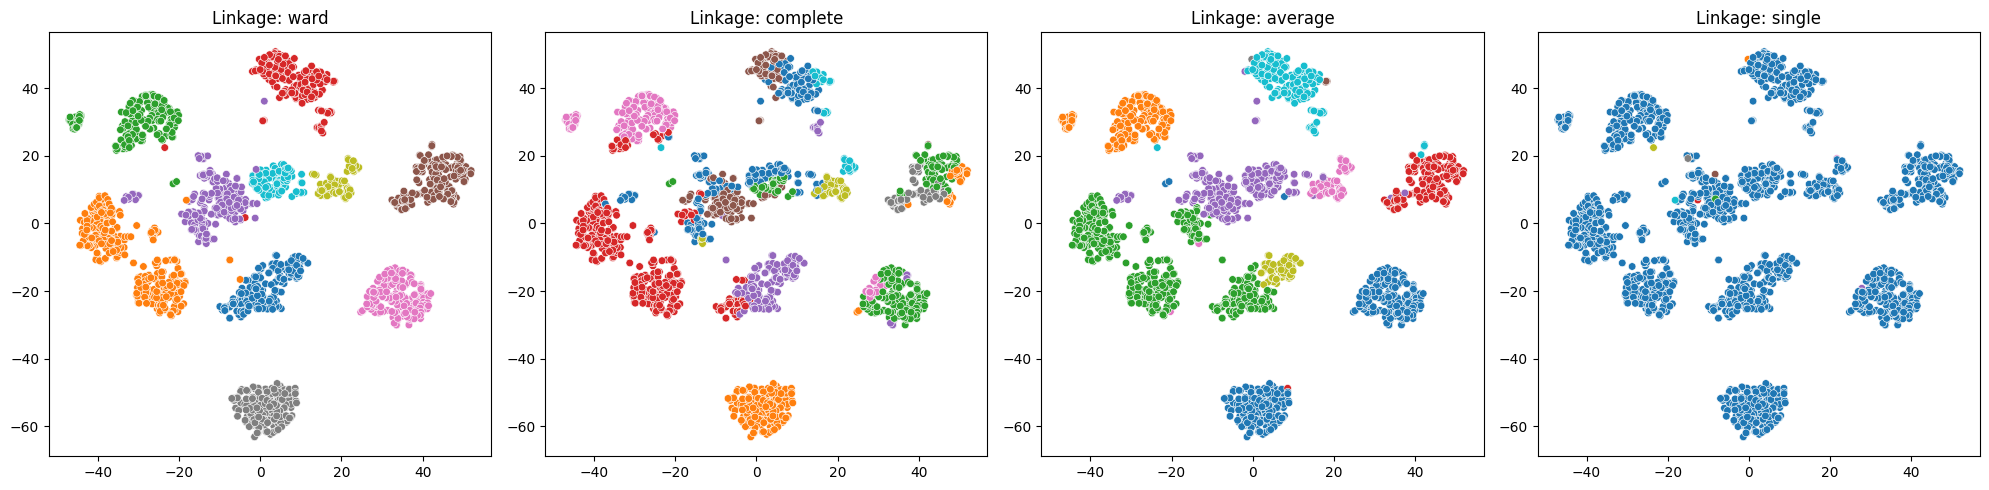

In [ ]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset
digits = load_digits()
X = digits.data
k = len(set(digits.target))  # 10 clusters

# Proyección a 2D con t-SNE
X_tsne = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(X)

# Enlaces a comparar
linkages = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, linkage in zip(axes, linkages):
    model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = model.fit_predict(X)

    sns.scatterplot(
        x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab10',
        ax=ax, legend=None, s=30
    )
    ax.set_title(f"Linkage: {linkage}")

plt.tight_layout()
plt.show()


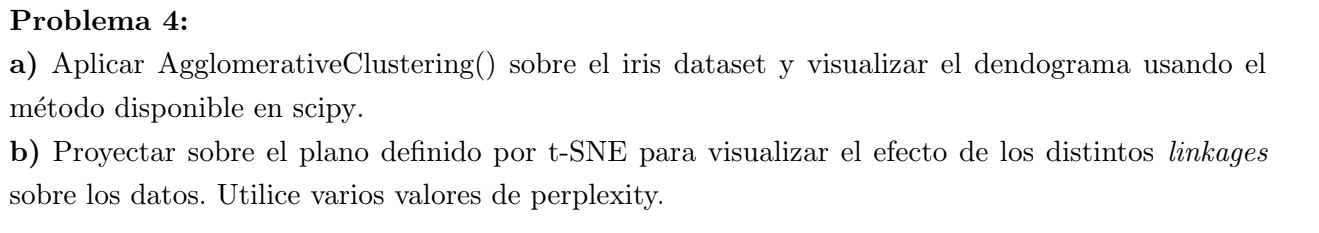

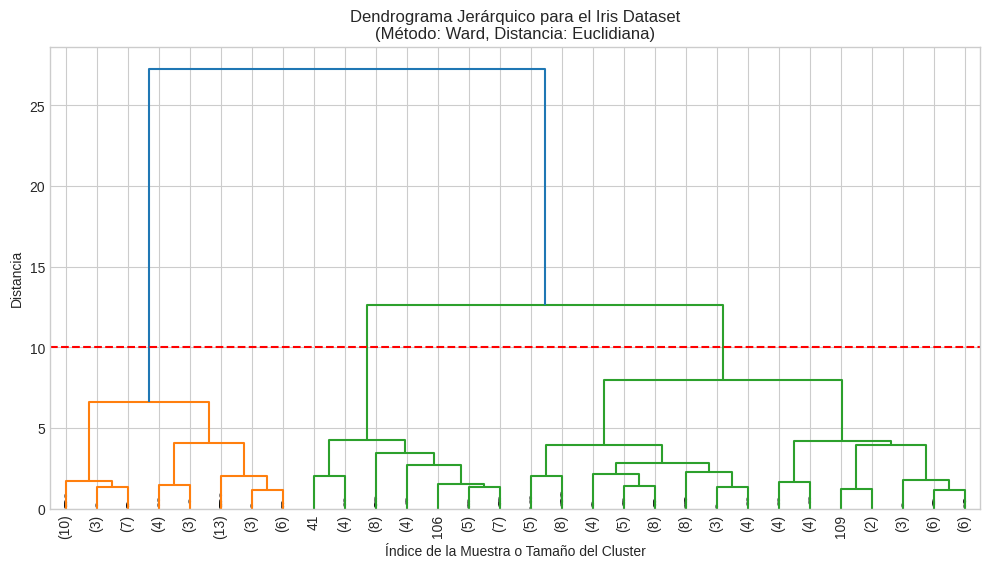

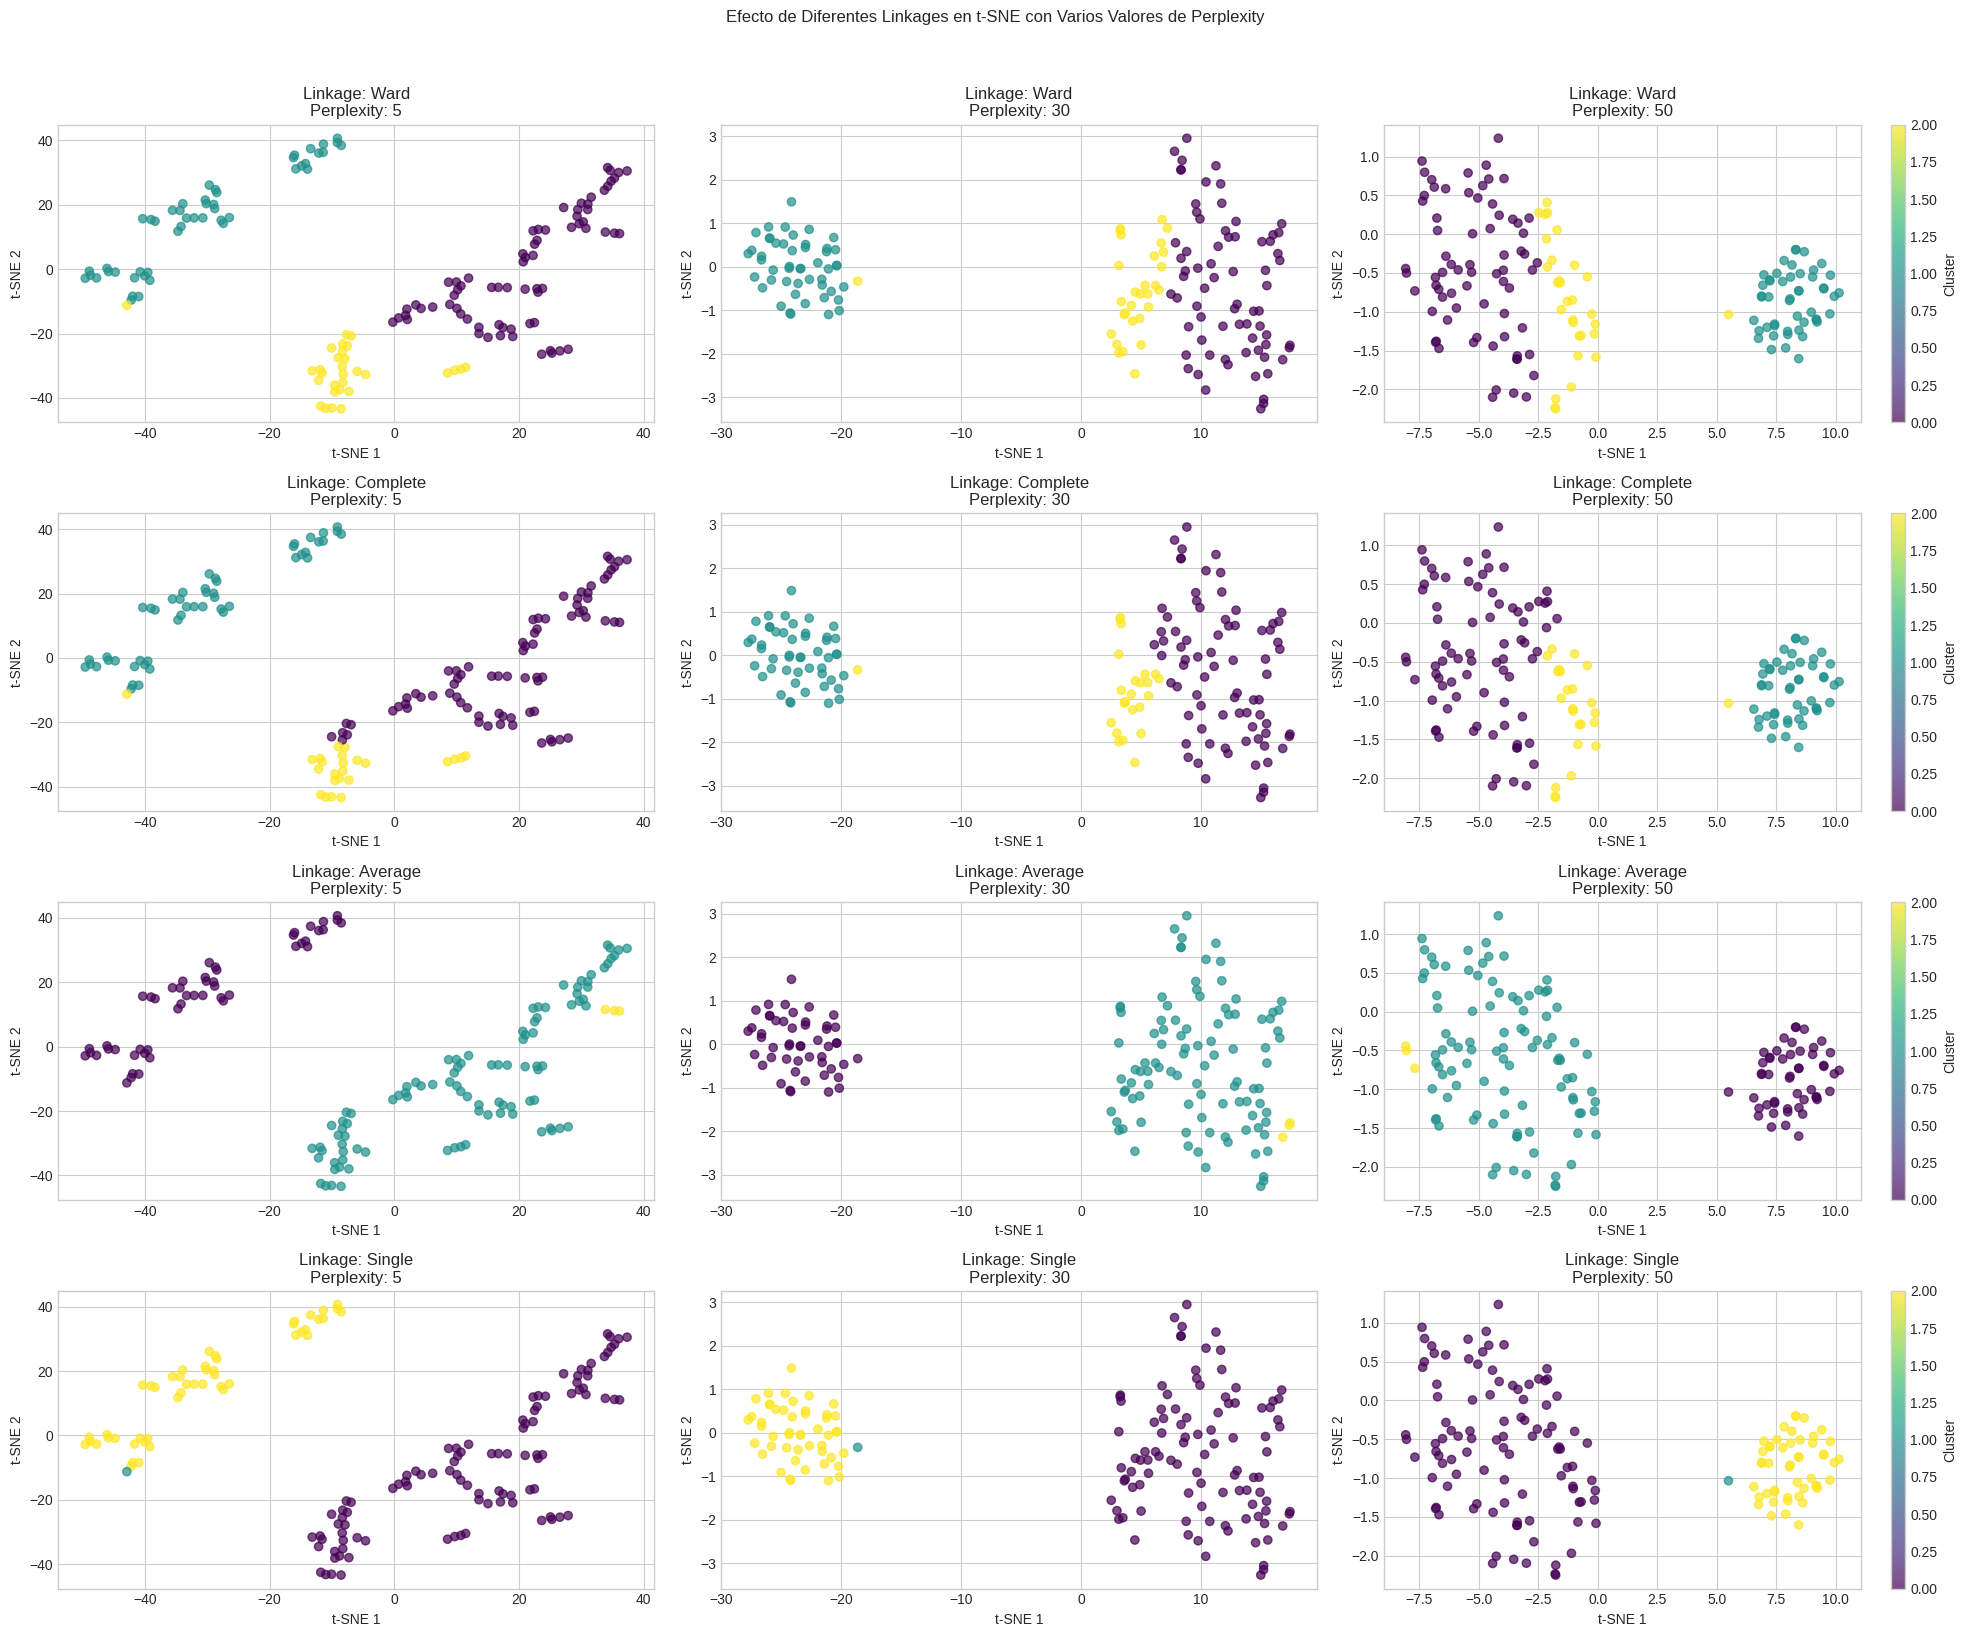


Comparación de Métricas por Método de Linkage:
+----------+------------+----------------------+------------------------+
| Linkage  | Perplexity | ARI (vs true labels) | N° Clusters Detectados |
+----------+------------+----------------------+------------------------+
|   ward   |     5      |        0.6153        |           3            |
|   ward   |     30     |        0.6153        |           3            |
|   ward   |     50     |        0.6153        |           3            |
| complete |     5      |        0.5726        |           3            |
| complete |     30     |        0.5726        |           3            |
| complete |     50     |        0.5726        |           3            |
| average  |     5      |        0.5621        |           3            |
| average  |     30     |        0.5621        |           3            |
| average  |     50     |        0.5621        |           3            |
|  single  |     5      |        0.5584        |           3    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Configuración de estilos para los gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

## ------------------------------------------
## Ejercicio 4.a: Aplicar AgglomerativeClustering y visualizar dendrograma
## ------------------------------------------

# 1. Cargar el dataset iris
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# 2. Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Generar matriz de linkage para el dendrograma
Z = linkage(X_scaled, method='ward', metric='euclidean')

# 4. Visualizar dendrograma
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, show_leaf_counts=True,
           leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title('Dendrograma Jerárquico para el Iris Dataset\n(Método: Ward, Distancia: Euclidiana)')
plt.xlabel('Índice de la Muestra o Tamaño del Cluster')
plt.ylabel('Distancia')
plt.axhline(y=10, color='r', linestyle='--')  # Línea de corte sugerida
plt.show()

# 5. Aplicar AgglomerativeClustering con n_clusters=3 (sabemos que iris tiene 3 clases)
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
cluster_labels = agg_clustering.fit_predict(X_scaled)

## ------------------------------------------
## Ejercicio 4.b: Visualización con t-SNE y diferentes linkages
## ------------------------------------------

# Configuración de linkages a comparar
linkages = ['ward', 'complete', 'average', 'single']
perplexities = [5, 30, 50]  # Diferentes valores de perplexity

# Aplicar t-SNE para visualización
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Crear figura para visualización
fig, axes = plt.subplots(len(linkages), len(perplexities), figsize=(20, 16))
plt.suptitle('Efecto de Diferentes Linkages en t-SNE con Varios Valores de Perplexity', y=1.02)

for i, linkage in enumerate(linkages):
    for j, perplexity in enumerate(perplexities):
        # Aplicar clustering aglomerativo con el linkage actual
        agg = AgglomerativeClustering(n_clusters=3, linkage=linkage)
        labels = agg.fit_predict(X_scaled)

        # Aplicar t-SNE con el perplexity actual
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        X_tsne_current = tsne.fit_transform(X_scaled)

        # Visualización
        ax = axes[i,j]
        scatter = ax.scatter(X_tsne_current[:, 0], X_tsne_current[:, 1], c=labels, cmap='viridis', alpha=0.7)
        ax.set_title(f'Linkage: {linkage.capitalize()}\nPerplexity: {perplexity}')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')

        # Añadir colorbar solo para la última columna
        if j == len(perplexities)-1:
            plt.colorbar(scatter, ax=ax, label='Cluster')

plt.tight_layout()
plt.show()

## ------------------------------------------
## Análisis Comparativo
## ------------------------------------------

# Crear una tabla comparativa de los resultados
from prettytable import PrettyTable
from sklearn.metrics import adjusted_rand_score

table = PrettyTable()
table.field_names = ["Linkage", "Perplexity", "ARI (vs true labels)", "N° Clusters Detectados"]

for linkage in linkages:
    agg = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    labels = agg.fit_predict(X_scaled)

    for perplexity in perplexities:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        X_tsne_current = tsne.fit_transform(X_scaled)

        # Calcular métricas
        ari = adjusted_rand_score(y, labels)
        n_clusters = len(np.unique(labels))

        table.add_row([linkage, perplexity, f"{ari:.4f}", n_clusters])

print("\nComparación de Métricas por Método de Linkage:")
print(table)

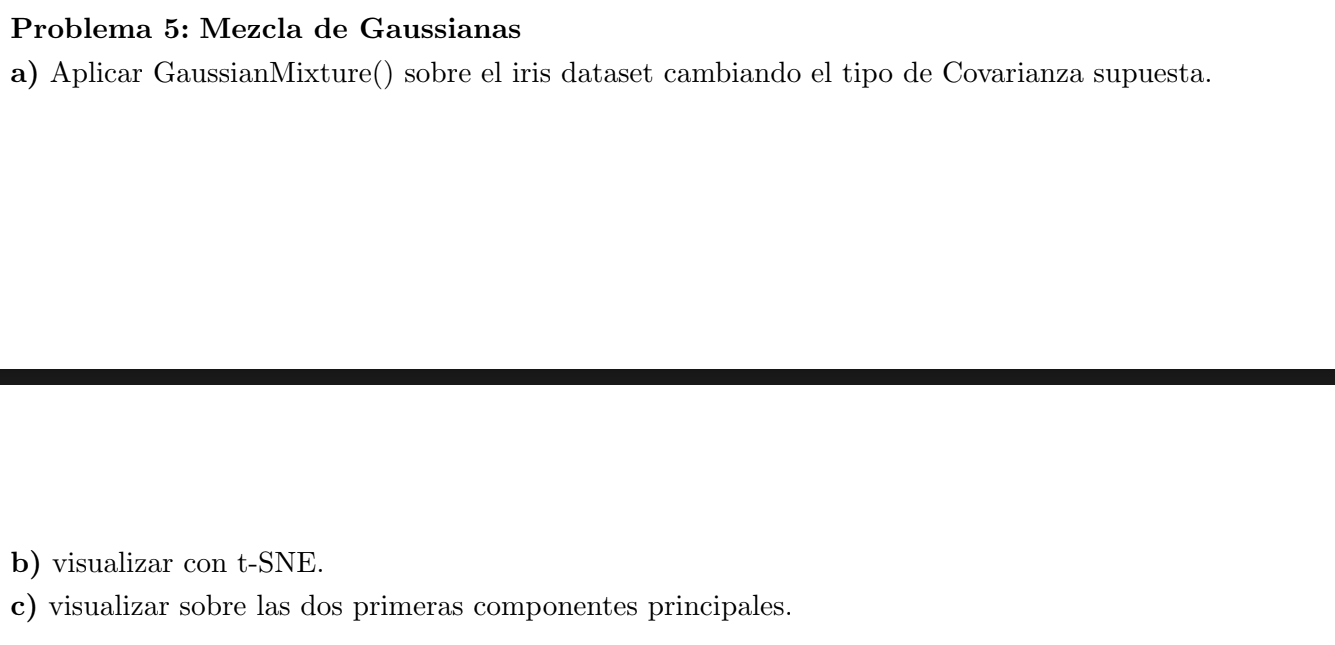

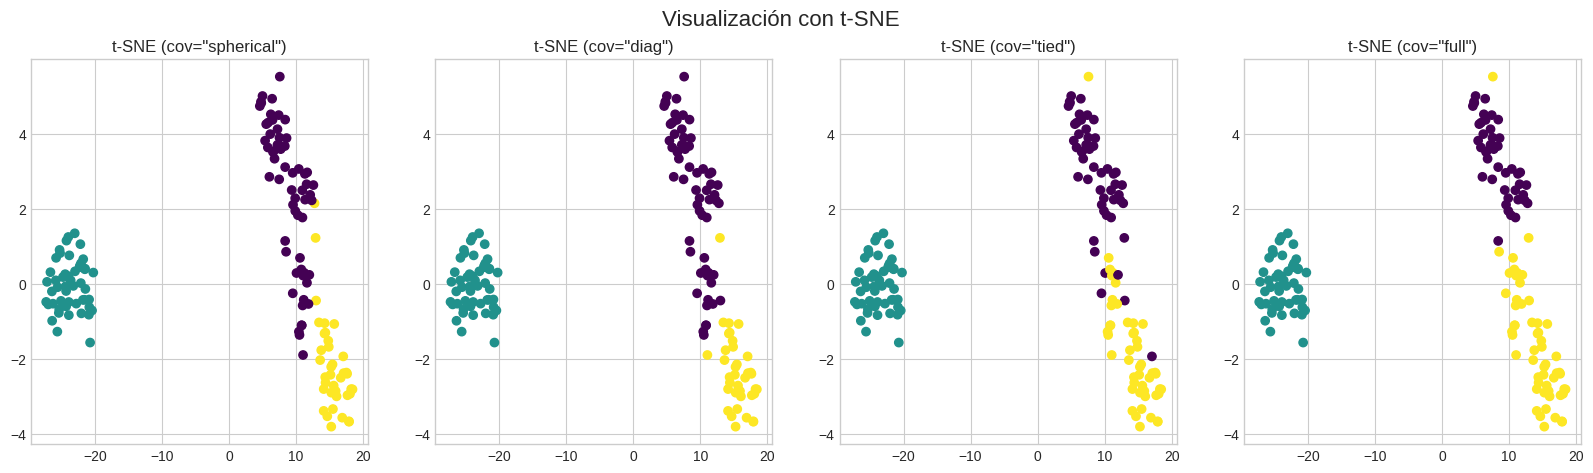

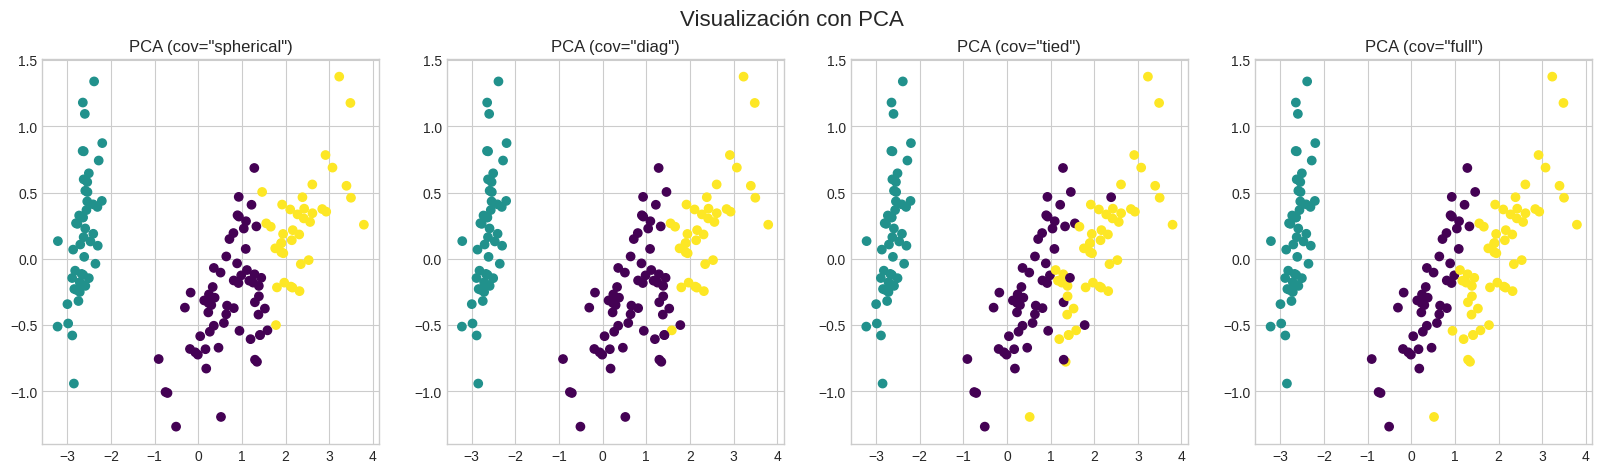

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Cargar el dataset Iris
iris = datasets.load_iris()
X = iris.data
y_true = iris.target

# Tipos de covarianza a probar
cov_types = ['spherical', 'diag', 'tied', 'full']

# Creamos una figura para comparar los resultados
fig_tsne, axes_tsne = plt.subplots(1, 4, figsize=(20, 5))
fig_pca, axes_pca = plt.subplots(1, 4, figsize=(20, 5))

for i, cov_type in enumerate(cov_types):
    # Ajustamos GaussianMixture con cada tipo de covarianza
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=0)
    gmm.fit(X)
    y_gmm = gmm.predict(X)

    # Visualización con t-SNE
    X_tsne = TSNE(n_components=2, random_state=0).fit_transform(X)
    axes_tsne[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_gmm, cmap='viridis')
    axes_tsne[i].set_title(f't-SNE (cov="{cov_type}")')

    # Visualización con PCA
    X_pca = PCA(n_components=2).fit_transform(X)
    axes_pca[i].scatter(X_pca[:, 0], X_pca[:, 1], c=y_gmm, cmap='viridis')
    axes_pca[i].set_title(f'PCA (cov="{cov_type}")')

fig_tsne.suptitle('Visualización con t-SNE', fontsize=16)
fig_pca.suptitle('Visualización con PCA', fontsize=16)

plt.show()

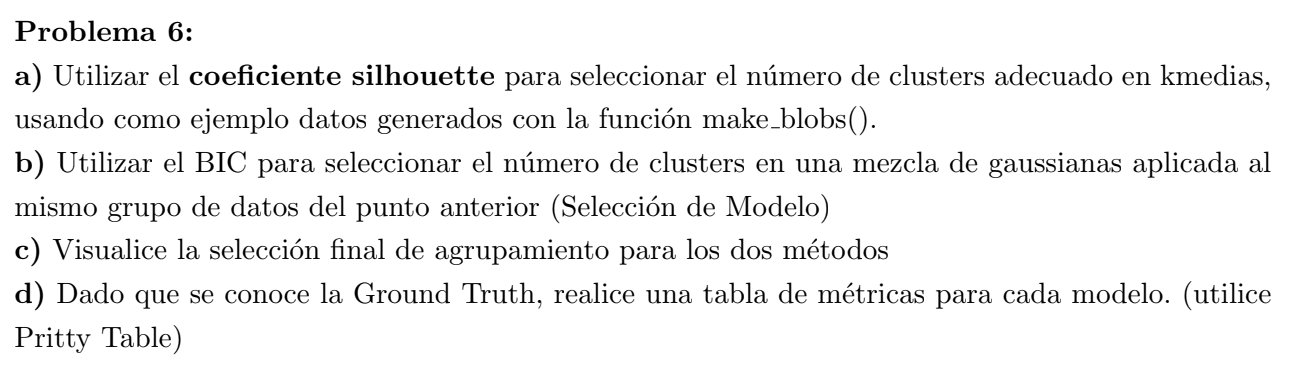

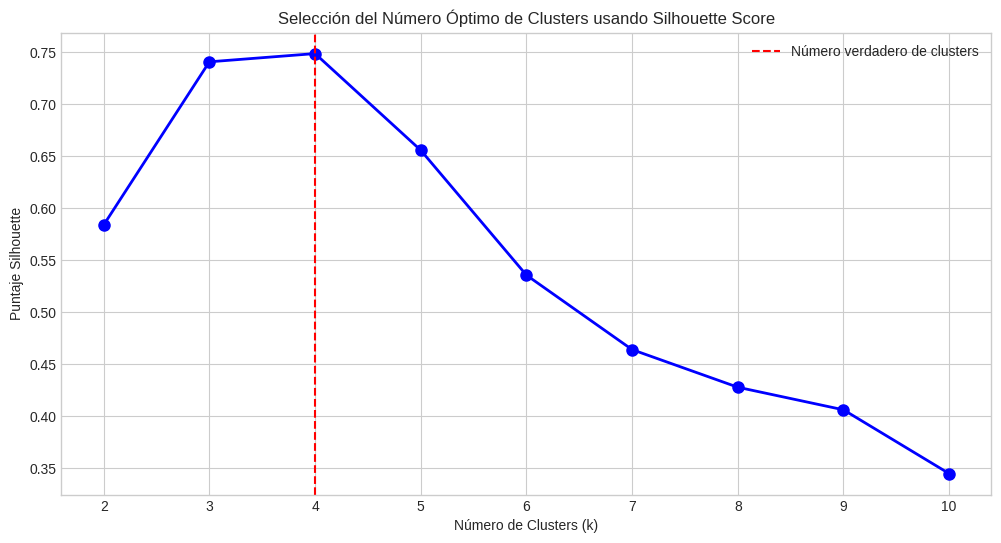

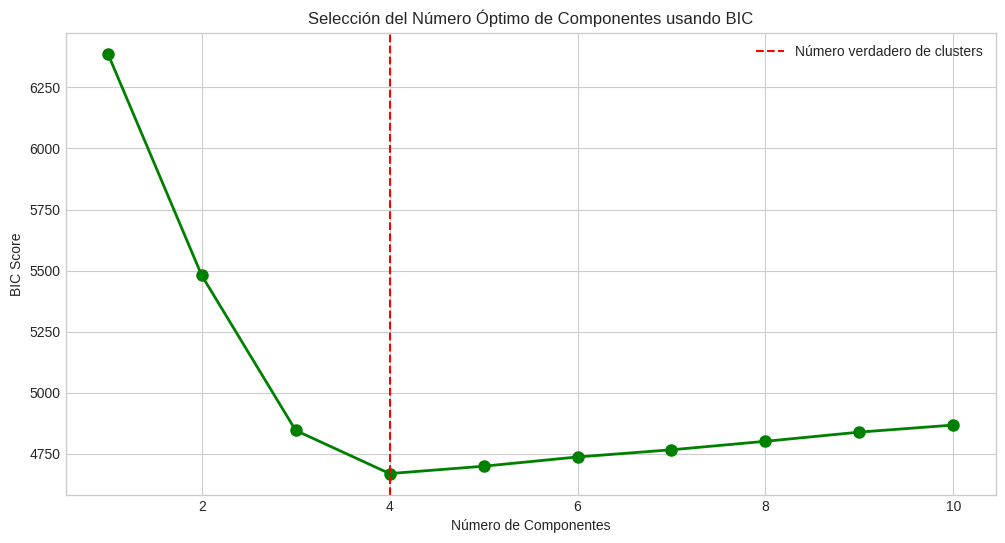

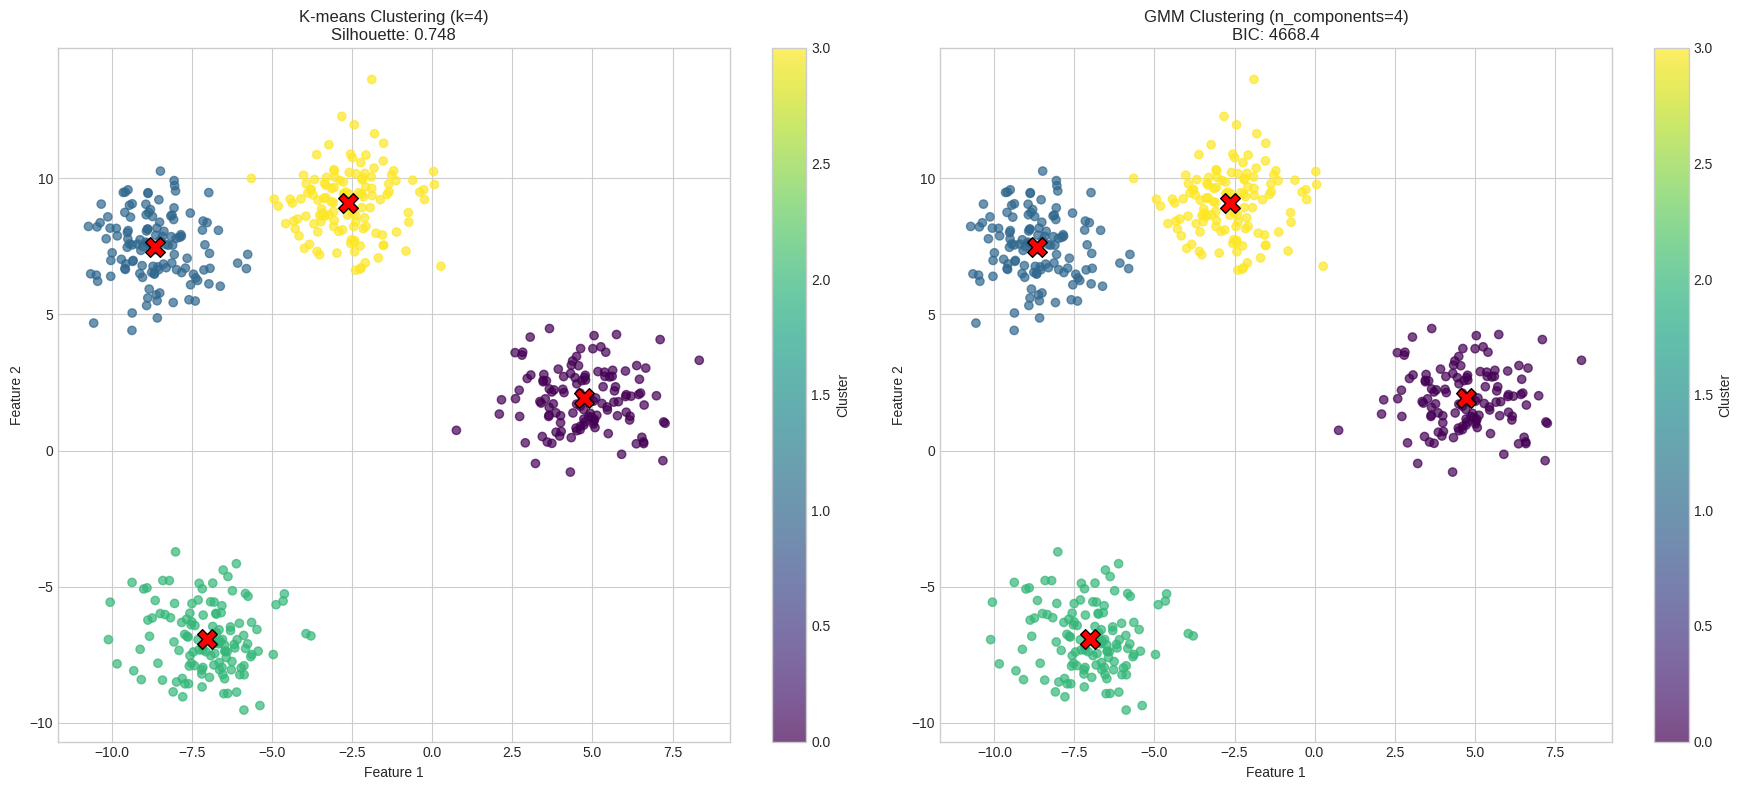


Comparación de Métricas entre K-means y GMM:
+---------------------------+---------+--------+
|          Métrica          | K-means |  GMM   |
+---------------------------+---------+--------+
|     Número de Clusters    |    4    |   4    |
| Adjusted Rand Index (ARI) |  1.0000 | 1.0000 |
|      Silhouette Score     |  0.7483 | 0.7483 |
|         BIC Score         |   N/A   | 4668.4 |
+---------------------------+---------+--------+


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from prettytable import PrettyTable

# Configuración de estilos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (18, 10)

## ------------------------------------------
## Parte 6.a: Selección de clusters con Silhouette en K-means
## ------------------------------------------

# 1. Generar datos sintéticos
X, y_true = make_blobs(n_samples=500, centers=4, cluster_std=1.2, random_state=42)

# 2. Calcular Silhouette para diferentes valores de k
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 3. Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntaje Silhouette')
plt.title('Selección del Número Óptimo de Clusters usando Silhouette Score')
plt.axvline(x=4, color='r', linestyle='--', label='Número verdadero de clusters')
plt.grid(True)
plt.legend()
plt.show()

## ------------------------------------------
## Parte 6.b: Selección de clusters con BIC en GMM
## ------------------------------------------

# 1. Calcular BIC para diferentes números de componentes
n_components_range = range(1, 11)
bic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))

# 2. Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, bic_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Número de Componentes')
plt.ylabel('BIC Score')
plt.title('Selección del Número Óptimo de Componentes usando BIC')
plt.axvline(x=4, color='r', linestyle='--', label='Número verdadero de clusters')
plt.grid(True)
plt.legend()
plt.show()

## ------------------------------------------
## Parte 6.c: Visualización de los agrupamientos finales
## ------------------------------------------

# 1. Aplicar K-means con k óptimo
optimal_k = np.argmax(silhouette_scores) + 2  # +2 porque empezamos en k=2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# 2. Aplicar GMM con n_components óptimo
optimal_n = np.argmin(bic_scores) + 1  # +1 porque empezamos en 1
gmm = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X)

# 3. Visualizar resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# K-means
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, marker='X', c='red', edgecolor='black')
ax1.set_title(f'K-means Clustering (k={optimal_k})\nSilhouette: {silhouette_scores[optimal_k-2]:.3f}')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# GMM
scatter2 = ax2.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
ax2.scatter(gmm.means_[:, 0], gmm.means_[:, 1],
            s=200, marker='X', c='red', edgecolor='black')
ax2.set_title(f'GMM Clustering (n_components={optimal_n})\nBIC: {bic_scores[optimal_n-1]:.1f}')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

plt.tight_layout()
plt.show()

## ------------------------------------------
## Parte 6.d: Tabla comparativa de métricas
## ------------------------------------------

# Calcular métricas para ambos métodos
metrics = {
    'K-means': {
        'ARI': adjusted_rand_score(y_true, kmeans_labels),
        'Silhouette': silhouette_score(X, kmeans_labels),
        'N Clusters': optimal_k
    },
    'GMM': {
        'ARI': adjusted_rand_score(y_true, gmm_labels),
        'Silhouette': silhouette_score(X, gmm_labels),
        'N Clusters': optimal_n,
        'BIC': bic_scores[optimal_n-1]
    }
}

# Crear tabla comparativa
table = PrettyTable()
table.field_names = ["Métrica", "K-means", "GMM"]

table.add_row(["Número de Clusters",
               metrics['K-means']['N Clusters'],
               metrics['GMM']['N Clusters']])
table.add_row(["Adjusted Rand Index (ARI)",
               f"{metrics['K-means']['ARI']:.4f}",
               f"{metrics['GMM']['ARI']:.4f}"])
table.add_row(["Silhouette Score",
               f"{metrics['K-means']['Silhouette']:.4f}",
               f"{metrics['GMM']['Silhouette']:.4f}"])
table.add_row(["BIC Score",
               "N/A",
               f"{metrics['GMM']['BIC']:.1f}"])

print("\nComparación de Métricas entre K-means y GMM:")
print(table)

Parte 6.a: Selección de clusters con Silhouette en K-means

    Generamos datos sintéticos con 4 clusters usando make_blobs.

    Calculamos el Silhouette Score para valores de k entre 2 y 10.

    Visualizamos los resultados para identificar el k óptimo (máximo Silhouette Score).

Parte 6.b: Selección de clusters con BIC en GMM

    Calculamos el BIC (Bayesian Information Criterion) para números de componentes entre 1 y 10.

    Visualizamos los resultados para identificar el número óptimo de componentes (mínimo BIC).

Parte 6.c: Visualización de los agrupamientos finales

    Aplicamos K-means con el k óptimo encontrado.

    Aplicamos GMM con el número óptimo de componentes.

    Visualizamos ambos resultados con sus centroides/medias.

Parte 6.d: Tabla comparativa de métricas

    Calculamos el Adjusted Rand Index (ARI) y Silhouette Score para ambos métodos.

    Creamos una tabla comparativa con PrettyTable.

Resultados Esperados

    Gráficos de Selección:

        Ambos métodos deberían identificar correctamente 4 clusters.

        El Silhouette Score tendrá un máximo en k=4.

        El BIC tendrá un mínimo en n_components=4.

    Visualización de Clusters:

        K-means mostrará clusters esféricos con centroides claros.

        GMM mostrará clusters que pueden tener formas más flexibles.

    Tabla Comparativa:

        Ambos métodos deberían tener ARI alto (cercano a 1).

        GMM podría tener mejor ARI que K-means en este caso.

        K-means tendrá mejor Silhouette Score por su naturaleza esférica.

Interpretación de Métricas
Métrica	K-means	GMM
Silhouette Score	Mide cohesión y separación	Menos relevante para formas no esféricas
BIC	No aplicable	Balance entre ajuste y complejidad
ARI	Comparación con ground truth	Mejor para evaluar calidad real